In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive')
sys.path.append('/content/drive/MyDrive/EPAM/datasets/predict_future_sales')

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
import lightgbm
import xgboost
import torch.nn as nn
from importlib import reload
from sklearn.model_selection import TimeSeriesSplit
from pylab import rcParams
from functools import reduce
import statistics 
import main as tsm
import cross_valid as tscv

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/TRAIN.csv')
items = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/items.csv', index_col = 'item_id')
items_cat = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/item_categories.csv', index_col = 'item_category_id')
city = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/city_copy.csv', index_col=None)
shops = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/shops_copy.csv', index_col='shop_id')

In [ ]:
#train[(train['item_id']==1472) & (train['date_block_num']==0) & (train['shop_id']==2)]
train

,date_block_num,shop_id,item_id,item_price,item_cnt_day,income,item_cat,city_id,day,weekday,year,month,week,population,date
0,0,19,18976,399.0,1.0,399.0,40,1,1,1,2013,1,1,429,2013-01-01
1,0,19,18284,199.0,1.0,199.0,55,1,1,1,2013,1,1,429,2013-01-01
2,0,19,18320,199.0,1.0,199.0,55,1,1,1,2013,1,1,429,2013-01-01
3,0,19,18329,299.0,1.0,299.0,55,1,1,1,2013,1,1,429,2013-01-01
4,0,19,19367,399.0,1.0,399.0,62,1,1,1,2013,1,1,429,2013-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,33,25,7087,699.0,1.0,699.0,30,0,31,5,2015,10,44,12108,2015-10-31
2935845,33,25,7172,1499.0,1.0,1499.0,20,0,31,5,2015,10,44,12108,2015-10-31
2935846,33,25,7202,199.0,1.0,199.0,30,0,31,5,2015,10,44,12108,2015-10-31
2935847,33,25,7780,198.0,1.0,198.0,30,0,31,5,2015,10,44,12108,2015-10-31


In [ ]:
train['date'] = pd.to_datetime(train['date'])
train.sort_values(by=['date','shop_id','item_id','item_cat'], ascending=True, inplace=True)
train.head(3)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,income,item_cat,city_id,day,weekday,year,month,week,population,date
492,0,2,991,99.0,1.0,99.0,67,17,1,1,2013,1,1,444,2013-01-01
491,0,2,1472,2599.0,1.0,2599.0,23,17,1,1,2013,1,1,444,2013-01-01
493,0,2,1905,249.0,1.0,249.0,30,17,1,1,2013,1,1,444,2013-01-01


In [ ]:
columns = ['shop_id','item_id', 'date_block_num']
G = train.groupby(columns, as_index=False).agg({
    'item_price' : ['mean'],
    'item_cat' : ['first'],
    'city_id' : ['first'],
    'year' : ['first'],
    'month' : ['first'],
    'item_cnt_day' : ['sum']
    })

In [ ]:
G.columns = ['shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cat', 'city_id', 'year', 'month','item_cnt_month']
G

,shop_id,item_id,date_block_num,item_price,item_cat,city_id,year,month,item_cnt_month
0,0,30,1,265.0,40,4,2013,2,31.0
1,0,31,1,434.0,37,4,2013,2,11.0
2,0,32,0,221.0,40,4,2013,1,6.0
3,0,32,1,221.0,40,4,2013,2,10.0
4,0,33,0,347.0,37,4,2013,1,3.0
...,...,...,...,...,...,...,...,...,...
1609119,59,22164,27,699.0,37,2,2015,4,2.0
1609120,59,22164,30,699.0,37,2,2015,7,1.0
1609121,59,22167,9,299.0,49,2,2013,10,1.0
1609122,59,22167,11,299.0,49,2,2013,12,2.0


In [ ]:
G.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cat',
       'city_id', 'year', 'month', 'item_cnt_month'],
      dtype='object')

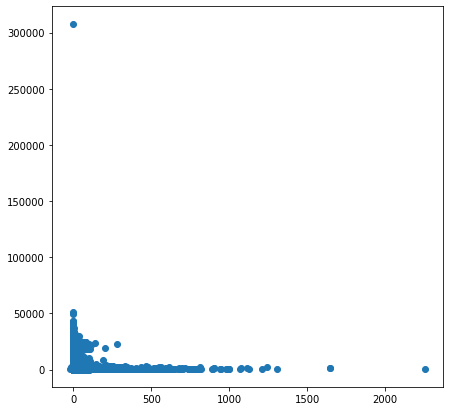

In [ ]:
rcParams['figure.figsize'] = 7, 7
plt.scatter(G['item_cnt_month'],G['item_price'])

In [ ]:
shop_sales = G.groupby('shop_id')['item_cnt_month'].mean()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


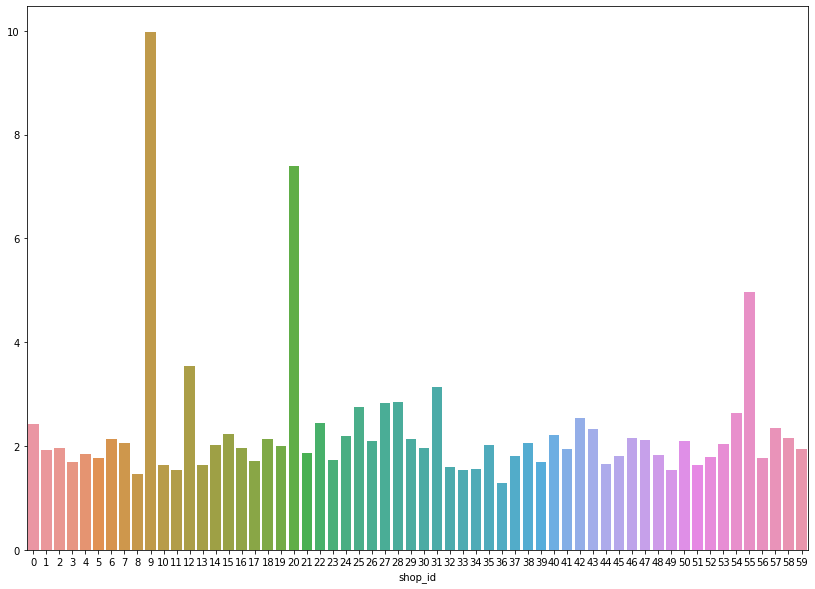

In [ ]:
rcParams['figure.figsize'] = 14, 10
sns.barplot(shop_sales.index, shop_sales.values)

In [ ]:
shops.loc[[9,12,20,31,55]]

,shop_name,city_id
shop_id,,
9,Выездная Торговля,29
12,Интернет-магазин ЧС,26
20,"Москва ""Распродажа""",0
31,"Москва ТЦ ""Семеновский""",0
55,Цифровой склад 1С-Онлайн,14


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


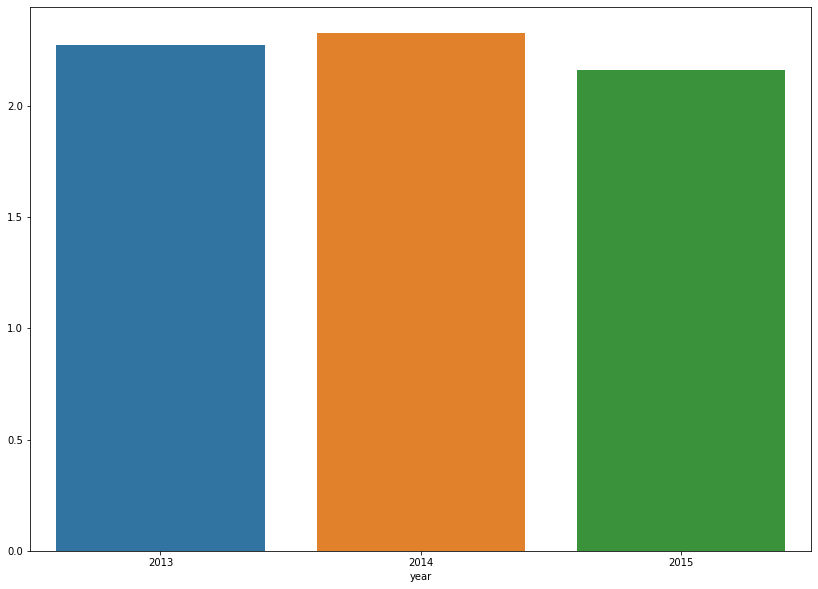

In [ ]:
year_sales = G.groupby('year')['item_cnt_month'].mean()
sns.barplot(year_sales.index, year_sales.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


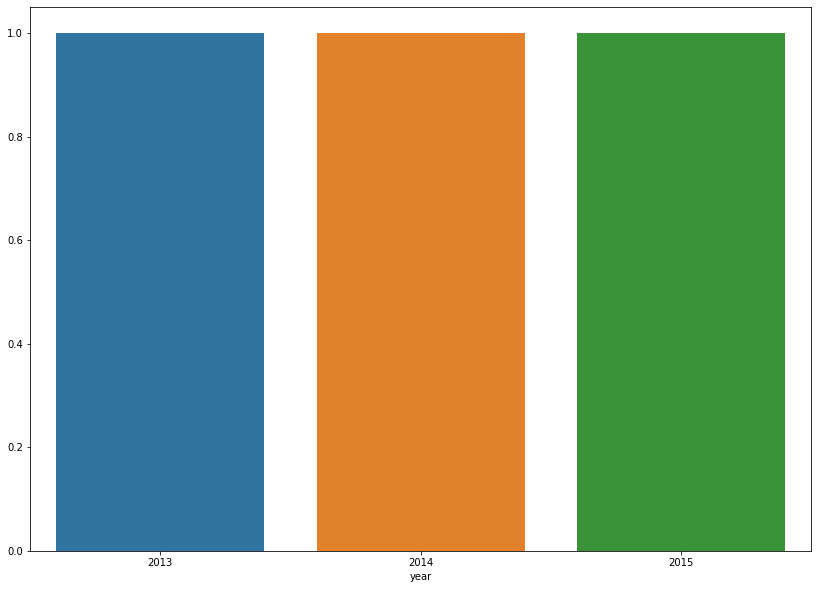

In [ ]:
year_sales = G.groupby('year')['item_cnt_month'].median()
sns.barplot(year_sales.index, year_sales.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


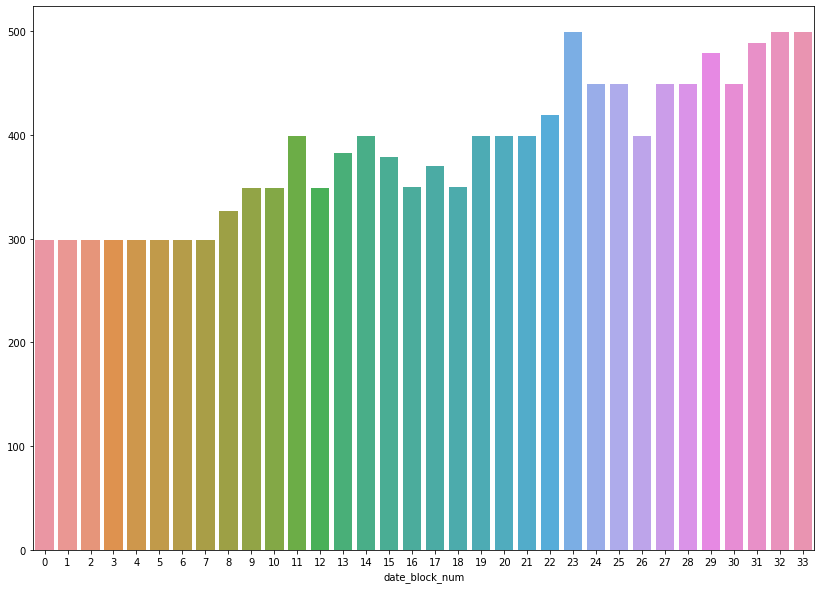

In [ ]:
price_median = G.groupby('date_block_num')['item_price'].median()
sns.barplot(price_median.index, price_median.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


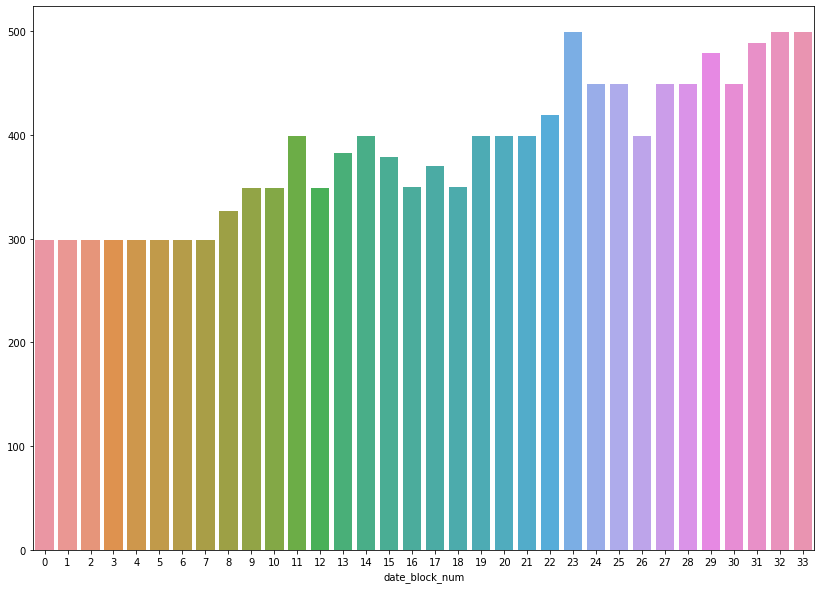

In [ ]:
price_mean = G.groupby('date_block_num')['item_price'].mean()
sns.barplot(price_median.index, price_median.values)

In [ ]:
G

,shop_id,item_id,date_block_num,item_price,item_cat,city_id,year,month,item_cnt_month
0,0,30,1,265.0,40,4,2013,2,31.0
1,0,31,1,434.0,37,4,2013,2,11.0
2,0,32,0,221.0,40,4,2013,1,6.0
3,0,32,1,221.0,40,4,2013,2,10.0
4,0,33,0,347.0,37,4,2013,1,3.0
...,...,...,...,...,...,...,...,...,...
1609119,59,22164,27,699.0,37,2,2015,4,2.0
1609120,59,22164,30,699.0,37,2,2015,7,1.0
1609121,59,22167,9,299.0,49,2,2013,10,1.0
1609122,59,22167,11,299.0,49,2,2013,12,2.0


In [ ]:
G.index = G['date_block_num']
G.drop(columns='date_block_num', inplace=True)

In [ ]:
G = G.groupby(columns[:2]).apply(lambda x : x.reindex(range(0,34)))
G

shop_id  item_id  ...  month  item_cnt_month
shop_id item_id date_block_num                    ...                       
0       30      0                   NaN      NaN  ...    NaN             NaN
                1                   0.0     30.0  ...    2.0            31.0
                2                   NaN      NaN  ...    NaN             NaN
                3                   NaN      NaN  ...    NaN             NaN
                4                   NaN      NaN  ...    NaN             NaN
...                                 ...      ...  ...    ...             ...
59      22167   29                  NaN      NaN  ...    NaN             NaN
                30                  NaN      NaN  ...    NaN             NaN
                31                  NaN      NaN  ...    NaN             NaN
                32                  NaN      NaN  ...    NaN             NaN
                33                  NaN      NaN  ...    NaN             NaN

[14420216 rows x 8 columns]

In [ ]:
G.drop(columns=['shop_id','item_id'], inplace=True)

In [ ]:
G.index

MultiIndex([( 0,    30,  0),
            ( 0,    30,  1),
            ( 0,    30,  2),
            ( 0,    30,  3),
            ( 0,    30,  4),
            ( 0,    30,  5),
            ( 0,    30,  6),
            ( 0,    30,  7),
            ( 0,    30,  8),
            ( 0,    30,  9),
            ...
            (59, 22167, 24),
            (59, 22167, 25),
            (59, 22167, 26),
            (59, 22167, 27),
            (59, 22167, 28),
            (59, 22167, 29),
            (59, 22167, 30),
            (59, 22167, 31),
            (59, 22167, 32),
            (59, 22167, 33)],
           names=['shop_id', 'item_id', 'date_block_num'], length=14420216)

In [ ]:
temp = G.groupby(columns[:2])

In [ ]:
G['item_cnt_month'] = temp['item_cnt_month'].apply(lambda x : x.fillna(value=0))

In [ ]:
G['item_price'] = temp['item_price'].apply(lambda x : x.fillna(method='ffill'))
G['item_price'] = temp['item_price'].apply(lambda x : x.fillna(method='backfill'))

In [ ]:
G

item_price  item_cat  ...  month  item_cnt_month
shop_id item_id date_block_num                        ...                       
0       30      0                    265.0       NaN  ...    NaN             0.0
                1                    265.0      40.0  ...    2.0            31.0
                2                    265.0       NaN  ...    NaN             0.0
                3                    265.0       NaN  ...    NaN             0.0
                4                    265.0       NaN  ...    NaN             0.0
...                                    ...       ...  ...    ...             ...
59      22167   29                   299.0       NaN  ...    NaN             0.0
                30                   299.0       NaN  ...    NaN             0.0
                31                   299.0       NaN  ...    NaN             0.0
                32                   299.0       NaN  ...    NaN             0.0
                33                   299.0       NaN  ...    NaN             0.0

[14420216 rows x 6 columns]

In [ ]:
G['item_cat'] = temp['item_cat'].apply(lambda x : x.fillna(value=x.dropna().iloc[0]))

In [ ]:
G['city_id'] = temp['city_id'].apply(lambda x : x.fillna(value=x.dropna().iloc[0]))

In [ ]:
#G['year'] = temp['year'].apply(lambda x : x.fillna(value=x.iloc[0]))

In [ ]:
def get_year(x):
    if x < 11:
        return 2013
    elif (11 >= x) and (x < 24):
        return 2014
    else:
        return 2015

In [ ]:
#G['year'] = G['']

In [ ]:
G['month'] = list(map(lambda x : x[2]%12 + 1, G.index)) #temp['month'].apply(lambda x : x.fillna(value=x.iloc[0]))
#del temp

In [ ]:
G

item_price  item_cat  ...  month  item_cnt_month
shop_id item_id date_block_num                        ...                       
0       30      0                    265.0      40.0  ...      1             0.0
                1                    265.0      40.0  ...      2            31.0
                2                    265.0      40.0  ...      3             0.0
                3                    265.0      40.0  ...      4             0.0
                4                    265.0      40.0  ...      5             0.0
...                                    ...       ...  ...    ...             ...
59      22167   29                   299.0      49.0  ...      6             0.0
                30                   299.0      49.0  ...      7             0.0
                31                   299.0      49.0  ...      8             0.0
                32                   299.0      49.0  ...      9             0.0
                33                   299.0      49.0  ...     10             0.0

[14420216 rows x 6 columns]

In [ ]:
temp = G.reset_index()
temp

,shop_id,item_id,date_block_num,item_price,item_cat,city_id,year,month,item_cnt_month
0,0,30,0,265.0,40.0,4.0,NaN,1,0.0
1,0,30,1,265.0,40.0,4.0,2013.0,2,31.0
2,0,30,2,265.0,40.0,4.0,NaN,3,0.0
3,0,30,3,265.0,40.0,4.0,NaN,4,0.0
4,0,30,4,265.0,40.0,4.0,NaN,5,0.0
...,...,...,...,...,...,...,...,...,...
14420211,59,22167,29,299.0,49.0,2.0,NaN,6,0.0
14420212,59,22167,30,299.0,49.0,2.0,NaN,7,0.0
14420213,59,22167,31,299.0,49.0,2.0,NaN,8,0.0
14420214,59,22167,32,299.0,49.0,2.0,NaN,9,0.0


In [ ]:
temp['year'] = temp['date_block_num'].apply(lambda x : get_year(x))

In [ ]:
temp['population'] = pd.Series(None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
temp

,shop_id,item_id,date_block_num,item_price,item_cat,city_id,year,month,item_cnt_month,population
0,0,30,0,265.0,40.0,4.0,2013,1,0.0,NaN
1,0,30,1,265.0,40.0,4.0,2013,2,31.0,NaN
2,0,30,2,265.0,40.0,4.0,2013,3,0.0,NaN
3,0,30,3,265.0,40.0,4.0,2013,4,0.0,NaN
4,0,30,4,265.0,40.0,4.0,2013,5,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
14420211,59,22167,29,299.0,49.0,2.0,2015,6,0.0,NaN
14420212,59,22167,30,299.0,49.0,2.0,2015,7,0.0,NaN
14420213,59,22167,31,299.0,49.0,2.0,2015,8,0.0,NaN
14420214,59,22167,32,299.0,49.0,2.0,2015,9,0.0,NaN


In [ ]:
city.head(3)

,city,2013,2014,2015
0,Москва,11980,12108,12108
1,Курск,429,431,435
2,Ярославль,599,602,604


In [ ]:
items

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40
...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",31
22166,Язык запросов 1С:Предприятия [Цифровая версия],54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49


In [ ]:
city

,city,2013,2014,2015
0,Москва,11980,12108,12108
1,Курск,429,431,435
2,Ярославль,599,602,604
3,Самара,1172,1172,1172
4,Якутск,286,294,299
5,Сергиев,108,107,106
6,Балашиха,235,247,261
7,Воронеж,1004,1015,1024
8,Мытищи,179,183,187
9,Сургут,326,332,341


In [ ]:
temp[['shop_id','date_block_num','city_id','month']] = temp[['shop_id','date_block_num','city_id','month']].astype(np.uint8)
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14420216 entries, 0 to 14420215
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   shop_id         uint8  
 1   item_id         int64  
 2   date_block_num  uint8  
 3   item_price      float64
 4   item_cat        float64
 5   city_id         uint8  
 6   year            int64  
 7   month           uint8  
 8   item_cnt_month  float64
 9   population      float64
dtypes: float64(4), int64(2), uint8(4)
memory usage: 715.1 MB


In [ ]:
temp[['item_id','year','item_cat']] = temp[['item_id','year','item_cat']].astype(np.uint16)
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14420216 entries, 0 to 14420215
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   shop_id         uint8  
 1   item_id         uint16 
 2   date_block_num  uint8  
 3   item_price      float64
 4   item_cat        uint16 
 5   city_id         uint8  
 6   year            uint16 
 7   month           uint8  
 8   item_cnt_month  float64
 9   population      float64
dtypes: float64(3), uint16(3), uint8(4)
memory usage: 467.6 MB


In [ ]:
temp[['item_price','item_cnt_month']] = temp[['item_price','item_cnt_month']].astype(np.float32)
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14420216 entries, 0 to 14420215
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   shop_id         uint8  
 1   item_id         uint16 
 2   date_block_num  uint8  
 3   item_price      float32
 4   item_cat        uint16 
 5   city_id         uint8  
 6   year            uint16 
 7   month           uint8  
 8   item_cnt_month  float32
 9   population      float64
dtypes: float32(2), float64(1), uint16(3), uint8(4)
memory usage: 357.6 MB


In [ ]:
temp

,shop_id,item_id,date_block_num,item_price,item_cat,city_id,year,month,item_cnt_month,population
0,0,30,0,265.0,40,4,2013,1,0.0,NaN
1,0,30,1,265.0,40,4,2013,2,31.0,NaN
2,0,30,2,265.0,40,4,2013,3,0.0,NaN
3,0,30,3,265.0,40,4,2013,4,0.0,NaN
4,0,30,4,265.0,40,4,2013,5,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
14420211,59,22167,29,299.0,49,2,2015,6,0.0,NaN
14420212,59,22167,30,299.0,49,2,2015,7,0.0,NaN
14420213,59,22167,31,299.0,49,2,2015,8,0.0,NaN
14420214,59,22167,32,299.0,49,2,2015,9,0.0,NaN


In [ ]:
temp['population'] = temp[['city_id','year']].apply(lambda x : city.loc[x[0],str(int(x[1]))], axis=1)

In [ ]:
temp['population'] = temp['population'].astype(np.uint16)

In [ ]:
temp.to_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/monthly_sales_train.csv', index=None, index_label=None)